In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(14)

In [9]:
url = 'https://raw.githubusercontent.com/sztyberj/Real-Estate-Price-Prediction/refs/heads/main/data/processed/v1_2025_04_30.csv'
data = pd.read_csv(url, sep=';')

data_shuffled = data.sample(frac=1, random_state=14).reset_index(drop=True)
data = data_shuffled.to_numpy()

n = len(data)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

df_train = data[:train_end]
df_val   = data[train_end:val_end]
df_test  = data[val_end:]

#train set
y_train = df_train[:, 0]
X_train = df_train[:, 1:]

#val/dev set
y_val = df_val[:, 0]
X_val = df_val[:, 1:]

#test/test set
y_test = df_test[:, 0]
X_test = df_test[:, 1:]


print(f"Train size: {X_train.shape[0]}")
print(f"Val size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 7318
Val size: 1568
Test size: 1569


In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=14)

mse_scores = []
r2_scores = []

In [16]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=14),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=14, n_jobs=-1),
    'XGBoost Regressor': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=14, n_jobs=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=14)
}

results_summary = []
trained_models = {}

In [17]:
for model_name, model_instance in models.items():
    print({model_name})
    model_instance.fit(X_train, y_train)
    trained_models[model_name] = model_instance

    # Validation
    y_val_pred = model_instance.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"MSE Val {model_name}: {val_mse:.4f}")
    print(f"R2 Val {model_name}: {val_r2:.4f}")

    results_summary.append({
        'Model': model_name,
        'Val_MSE': val_mse,
        'Val_R2': val_r2
    })

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values(by='Val_MSE', ascending=True) # Sortuj po MSE na zbiorze walidacyjnym
print("\n--- Summary ---")
print(results_df.to_string())

{'Linear Regression'}
MSE Val Linear Regression: 0.0720
R2 Val Linear Regression: 0.9261
{'Decision Tree Regressor'}
MSE Val Decision Tree Regressor: 0.0093
R2 Val Decision Tree Regressor: 0.9904
{'Random Forest Regressor'}
MSE Val Random Forest Regressor: 0.0045
R2 Val Random Forest Regressor: 0.9954
{'XGBoost Regressor'}
MSE Val XGBoost Regressor: 0.0049
R2 Val XGBoost Regressor: 0.9949
{'Gradient Boosting Regressor'}
MSE Val Gradient Boosting Regressor: 0.0086
R2 Val Gradient Boosting Regressor: 0.9912

--- Summary ---
                         Model   Val_MSE    Val_R2
2      Random Forest Regressor  0.004490  0.995394
3            XGBoost Regressor  0.004949  0.994923
4  Gradient Boosting Regressor  0.008618  0.991160
1      Decision Tree Regressor  0.009319  0.990440
0            Linear Regression  0.072037  0.926103



--- Final check on test set ---

Best Model: Random Forest Regressor
MSE Test Random Forest Regressor: 0.0037
R2 test Random Forest Regressor: 0.9964


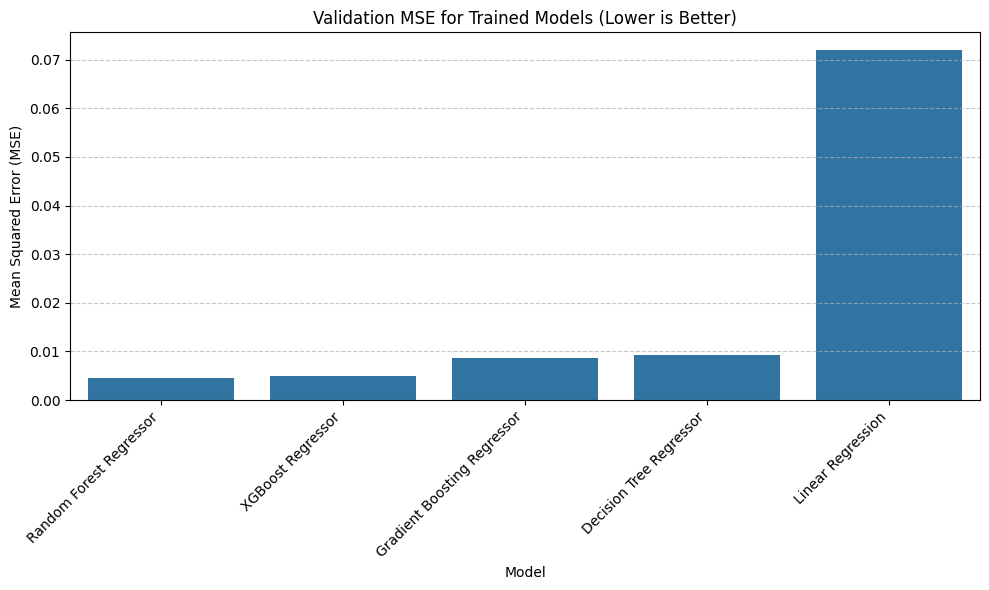

In [20]:
print("\n--- Final check on test set ---")

# Lowest Val_MSE
best_model_name_overall = results_df.iloc[0]['Model']
final_best_model = trained_models[best_model_name_overall]

print(f"\nBest Model: {best_model_name_overall}")

# Final predict
y_test_pred_final = final_best_model.predict(X_test)
test_mse_final = mean_squared_error(y_test, y_test_pred_final)
test_r2_final = r2_score(y_test, y_test_pred_final)

print(f"MSE Test {best_model_name_overall}: {test_mse_final:.4f}")
print(f"R2 test {best_model_name_overall}: {test_r2_final:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Val_MSE', data=results_df)
plt.title('Validation MSE for Trained Models (Lower is Better)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()